# **TRAINING**

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
os.environ['GRPC_VERBOSITY'] = 'ERROR'
os.environ['GRPC_TRACE'] = ''
os.environ['GRPC_DEFAULT_SSL_ROOTS_FILE_PATH'] = '/etc/ssl/certs/ca-certificates.crt'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model as tfkModel

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)
print(tfk.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import register_keras_serializable
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from keras.callbacks import Callback
import IPython.display as display
# import graphviz
from PIL import Image
import matplotlib.gridspec as gridspec
import json

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

E0000 00:00:1731186723.983451      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
E1109 21:12:04.025598624      13 oauth2_credentials.cc:238]            oauth_fetch: UNKNOWN:C-ares status is not ARES_SUCCESS qtype=A name=metadata.google.internal. is_balancer=0: Domain name not found {created_time:"2024-11-09T21:12:04.025582992+00:00", grpc_status:2}


2.16.1
3.5.0


## **DISTRIBUTION DEFINITIONS**

In [3]:
def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [4]:
# Setting che correct strategy for TPU / batch sizes
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

I0000 00:00:1731186747.522370      13 service.cc:145] XLA service 0x5708ed4acca0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731186747.522433      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1731186747.522438      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1731186747.522441      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1731186747.522444      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1731186747.522446      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1731186747.522449      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1731186747.522452      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1731186747.522454      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


Running on TPU: 
Running on 8 replicas
Num GPUs Available:  0
Num TPUs Available:  8


In [5]:
batch_size = 32
if numTPU != 0:
    batch_size = strategy.num_replicas_in_sync * 8

print(f"Batch size: {batch_size}")

Batch size: 64


## **DATA PREPROCESSING**

In [6]:
data_path = "/kaggle/input/blood-cells/cleaned_training_set.npz"

In [7]:
data = np.load(data_path, allow_pickle=True)
lst = data.files
X = data[lst[0]]
y = data[lst[1]]

# Convert values in data to int
X = X.astype(int)

# Normalize data to the range [0, 1]
X = (X / 255).astype('float32')

# Create a mapping from label string to values

# Convert labels to categorical format using one-hot encoding
y = tf.keras.utils.to_categorical(y)

# Split data into training, validation, and test sets, maintaining class distribution
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.15, stratify=y)

# Splitting the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.24, stratify=y_train_val)

In [8]:
del X, y # to free up resources

In [9]:
# Print the shapes of the loaded datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training Data Shape: (7725, 96, 96, 3)
Training Label Shape: (7725, 8)
Validation Data Shape: (2440, 96, 96, 3)
Validation Label Shape: (2440, 8)
Test Data Shape: (1794, 96, 96, 3)
Test Label Shape: (1794, 8)


In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().shuffle(10240).batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).cache().shuffle(4096).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache().shuffle(2048).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [11]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

steps_per_epoch = y_train.shape[0] // batch_size

print("Input Shape: ", input_shape)
print("Output Shape: ", output_shape)
print("Steps per epoch: ", steps_per_epoch)

Input Shape:  (96, 96, 3)
Output Shape:  8
Steps per epoch:  120


## **CUSTOM CALLBACKS AND METRICS DEFINITIONS**

In [23]:
# Custom implementation of ReduceLROnPlateau
class CustomReduceLROnPlateau(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', factor=0.33, patience=20, min_lr=1e-8, verbose=1):
        super(CustomReduceLROnPlateau, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.new_lr = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        
        # Initialize best metric if it's the first epoch
        if self.best is None:
            self.best = current
            return

        # Check if the monitored metric has improved
        if current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1

            # If patience is exceeded, reduce the learning rate
            if self.wait >= self.patience:
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                if old_lr == self.min_lr:
                    return
                self.new_lr = max(old_lr * self.factor, self.min_lr)
                self.model.optimizer.learning_rate.assign(self.new_lr)
                
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: reducing learning rate to {self.new_lr}.")
                
                self.wait = 0  # Reset patience counter

In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler

def exp_lr_scheduler(curr_epoch, curr_lr, start= 40, rate= 0.008):
    """
    Learning rate scheduler function.

    This function adjusts the learning rate during training.
    It keeps the initial learning rate unchanged until the 40th epoch,
    after which it exponentially decreases the learning rate.

    Parameters:
    - curr_epoch: The current epoch index.
    - curr_lr: The current learning rate.
    - start: The epoch at which the exponential decay starts (default: 40).
    - rate: The rate controlling the decay (default: 0.008).

    Returns:
    - Updated learning rate.
    """
    if curr_epoch < start:
        return curr_lr
    else:
        return curr_lr * tf.math.exp(-rate)

In [13]:
# Custom callback class for real-time plotting
class RealTimePlot(Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['categorical_accuracy'])
        self.val_acc.append(logs['val_categorical_accuracy'])

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        self.ax_loss.set_ylim(top=2.5, bottom=0.0)
        self.ax_loss.legend()

        # Plot training and validation accuracy
        self.ax_acc.clear()
        self.ax_acc.plot(self.epochs, self.train_acc, label='Training Accuracy')
        self.ax_acc.plot(self.epochs, self.val_acc, label='Validation Accuracy')
        self.ax_acc.set_title('Training and Validation Accuracy')
        self.ax_acc.set_xlabel('Epoch')
        self.ax_acc.set_ylabel('Accuracy')
        self.ax_acc.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)

In [14]:
class DisplayLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the current learning rate from the optimizer and display it
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"Epoch {epoch+1} : Learning rate = {tf.keras.backend.get_value(lr)}")

## **MODEL DEFINITION**

In [15]:
@register_keras_serializable()
class CustomCastLayer(tfk.layers.Layer):
    def call(self, inputs):
        return tf.cast(inputs * 255, tf.uint8)

@register_keras_serializable()
class CustomAugmentLayer(tfk.layers.Layer):
    def __init__(self, max_rotation=30.0, **kwargs):
        super(CustomAugmentLayer, self).__init__(**kwargs)
        self.max_rotation = max_rotation / 360.00
        
    def call(self, inputs, training=False):
        if training:
            inputs = tf.image.random_flip_up_down(tf.image.random_flip_left_right(inputs))
            inputs = tf.image.random_brightness(inputs, max_delta=0.1)
            inputs = tf.image.random_contrast(inputs, lower=0.9, upper=1.1)
            
        return inputs

In [17]:
def create_model(shape=input_shape, n_labels=output_shape, convnext_trainable=False, #standard definitions
                 n_dense_layers=1, initial_dense_neurons=1024, min_neurons=64, # architecture definitions
                 include_dropout=False, dropout_rate=0.3, l2_lambda=0, # against overfitting
                 learning_rate=1e-4):
    
    # Seed for reproducibility
    tf.random.set_seed(seed)

    # The input layer
    inputs = tfkl.Input(shape=input_shape, name='Input')   

    # The two augmentation layers
    x = CustomCastLayer()(inputs)
    x = CustomAugmentLayer()(x, training=True)

    # The convnext layer with include top=False to take the convolutional part only
    convnext = tfk.applications.ConvNeXtBase(
                input_shape=input_shape,
                weights='imagenet',
                include_top=False
            )

    # Here we freeze the convnext to perform Tranfer Learning
    convnext.trainable = convnext_trainable

    x = convnext(x)
    x = tfkl.GlobalAveragePooling2D()(x)

    # Hidden layers building
    neurons = initial_dense_neurons
    for k in range(n_dense_layers):
        x = tfkl.Dense(units=neurons, activation='silu', name=f'Dense_layer_{k}', kernel_regularizer=tfk.regularizers.L2(l2_lambda))(x)
        if include_dropout:
            x = tfkl.Dropout(dropout_rate, name=f'Dropout_layer_{k}')(x)
        neurons = max(neurons // 2, min_neurons)
    outputs = tfkl.Dense(output_shape, activation='softmax', name='output_layer')(x)

    # Final model building
    model = tfk.Model(inputs=inputs, outputs=outputs, name='TF-CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    # Metrics definition
    METRICS = [tfk.metrics.CategoricalAccuracy()]
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=l2_lambda)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=METRICS)

    # Return the model
    return model

In [14]:
augmentation = tfk.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.25, value_range=(0,1)),
    tfkl.RandomContrast(0.35),
], name='Augmentation')

In [31]:
def build_model(shape=input_shape, n_labels=output_shape, convnext_trainable=False, #standard definitions
                 n_dense_layers=1, initial_dense_neurons=1024, min_neurons=64, # architecture definitions
                 include_dropout=False, dropout_rate=0.3, # against overfitting
                 learning_rate=1e-4):
    
    # Seed for reproducibility
    tf.random.set_seed(seed)

    # The input layer
    inputs = tfkl.Input(shape=input_shape, name='Input')

    augmented1 = tfkl.Lambda(lambda x: tf.cast(x * 255, tf.uint8))(inputs)
    #x = augmentation(augmented1)

    # The convnext layer with include top=False to take the convolutional part only
    convnext = tfk.applications.ConvNeXtBase(
                input_shape=input_shape,
                weights='imagenet',
                include_top=False
            )

    # Here we freeze the convnext to perform Tranfer Learning
    convnext.trainable = convnext_trainable

    x = convnext(augmented1)
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.BatchNormalization(name="batch_normalization")(x)

    # Hidden layers building
    neurons = initial_dense_neurons
    for k in range(n_dense_layers):
        x = tfkl.Dense(units=neurons, activation='silu', name=f'Dense_layer_{k}')(x)
        if include_dropout:
            x = tfkl.Dropout(dropout_rate, name=f'Dropout_layer_{k}')(x)
        neurons = max(neurons // 2, min_neurons)
    outputs = tfkl.Dense(output_shape, activation='softmax', name='output_layer')(x)

    # Final model building
    model = tfk.Model(inputs=inputs, outputs=outputs, name='TF-CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    # Metrics definition
    METRICS = [tfk.metrics.CategoricalAccuracy()]
    optimizer = tfk.optimizers.AdamW(learning_rate)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=METRICS)

    # Return the model
    return model

## **TRANSFER LEARNING**

In [18]:
# Best values found so far
n_dense_layers = 3
dropout_rate = 0.35
include_dropout = True
l2_lambda = 2e-2

epochs = 150

In [19]:
# Build the model with specified input and output shapes
with strategy.scope():
    model = create_model(n_dense_layers=n_dense_layers, include_dropout=True, dropout_rate=dropout_rate)

# Display a summary of the model architecture
model.summary(expand_nested=False, show_trainable=True)

I0000 00:00:1731186814.800695      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "TF-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ custom_cast_layer           │ (None, 96, 96, 3)     │          0 │   -   │
│ (CustomCastLayer)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ custom_augment_layer        │ (None, 96, 96, 3)     │          0 │   -   │
│ (CustomAugmentLayer)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ convnext_base (Functional)  │ (None, 3, 3, 1024)    │ 87,566,464 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1024)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dense_layer_0 (Dense)       │ (None, 1024)          │  1,049,600 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dropout_layer_0 (Dropout)   │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dense_layer_1 (Dense)       │ (None, 512)           │    524,800 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dropout_layer_1 (Dropout)   │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dense_layer_2 (Dense)       │ (None, 256)           │    131,328 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dropout_layer_2 (Dropout)   │ (None, 256)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ output_layer (Dense)        │ (None, 8)             │      2,056 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 89,274,248 (340.55 MB)

 Trainable params: 1,707,784 (6.51 MB)

 Non-trainable params: 87,566,464 (334.04 MB)

In [24]:
# Define the patience value for early stopping
patience = 15

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

lr_reducer = CustomReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=10, min_lr=1e-8)
#lr_schedule = LearningRateScheduler(exp_lr_scheduler)
plot_callback = RealTimePlot()

# Store the callback in a list
callbacks = [early_stopping, plot_callback, lr_reducer, DisplayLearningRateCallback()]

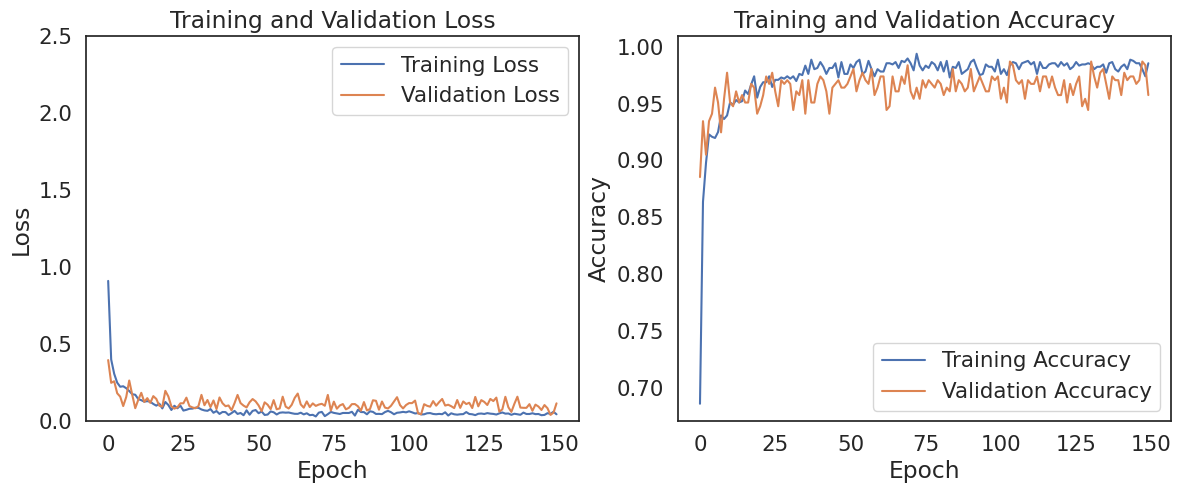

Epoch 150 : Learning rate = 2.4414061883248905e-08
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - categorical_accuracy: 0.9780 - loss: 0.0602 - val_categorical_accuracy: 0.9574 - val_loss: 0.1162


In [25]:
# Train the model with early stopping callback
history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    callbacks=callbacks
).history

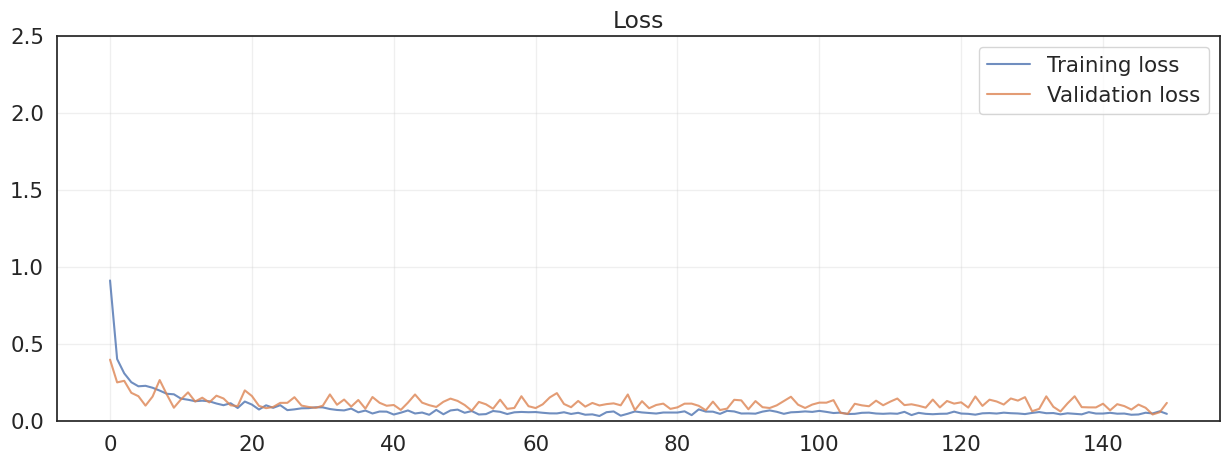

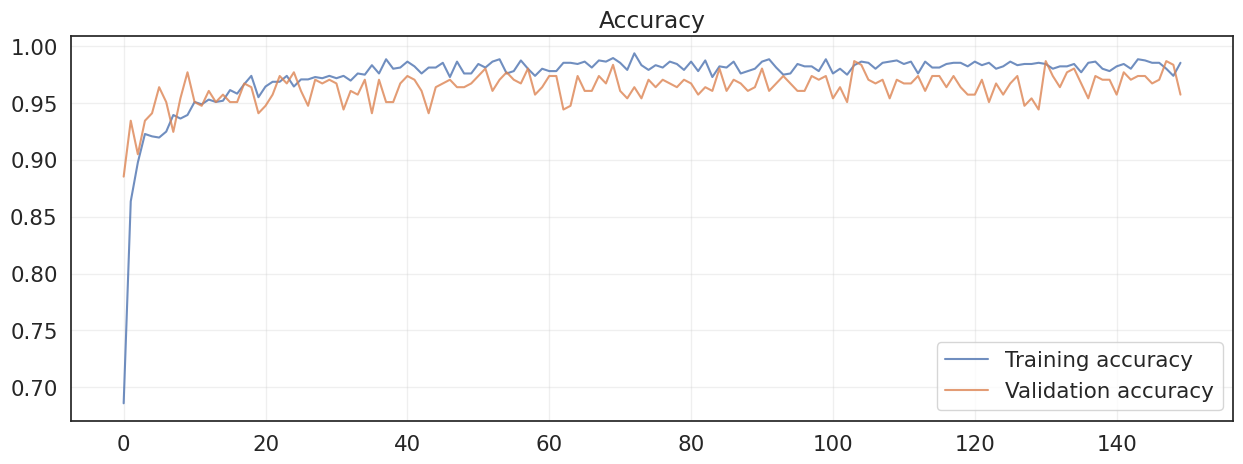

In [26]:
# Plot training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.ylim(top=2.5, bottom=0.0)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 5))
plt.plot(history['categorical_accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_categorical_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [27]:
# Save the trained model to a file with the accuracy included in the filename
with strategy.scope():
    model_weights_filename = 'MODEL.weights.h5'
    model.save_weights(model_weights_filename)

In [28]:
LABELS = [0, 1, 2, 3, 4, 5, 6, 7]

## **TRANSFER LEARNING EVALUATIONS**

In [29]:
def evaluations(model, ds, y_ds, labels, name):
    # Predict class probabilities and get predicted classes
    ds_predictions = model.predict(ds, verbose=0)
    ds_predictions = np.argmax(ds_predictions, axis=-1)
    
    # Extract ground truth classes
    ds_gt = np.argmax(y_ds, axis=-1)
    
    # Calculate and display training set accuracy
    ds_accuracy = accuracy_score(ds_gt, ds_predictions)
    print(f'Accuracy score over the {name} set: {round(ds_accuracy, 4)}')
    
    # Calculate and display training set precision
    ds_precision = precision_score(ds_gt, ds_predictions, average='weighted')
    print(f'Precision score over the {name} set: {round(ds_precision, 4)}')
    
    # Calculate and display training set recall
    ds_recall = recall_score(ds_gt, ds_predictions, average='weighted')
    print(f'Recall score over the {name} set: {round(ds_recall, 4)}')
    
    # Calculate and display training set F1 score
    ds_f1 = f1_score(ds_gt, ds_predictions, average='weighted')
    print(f'F1 score over the {name} set: {round(ds_f1, 4)}')
    
    # Compute the confusion matrix
    cm = confusion_matrix(ds_gt, ds_predictions)
    
    # Create labels combining confusion matrix values
    #labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)
    
    # Plot the confusion matrix with class labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=cm, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

Accuracy score over the training set: 0.9896
Precision score over the training set: 0.9897
Recall score over the training set: 0.9896
F1 score over the training set: 0.9896


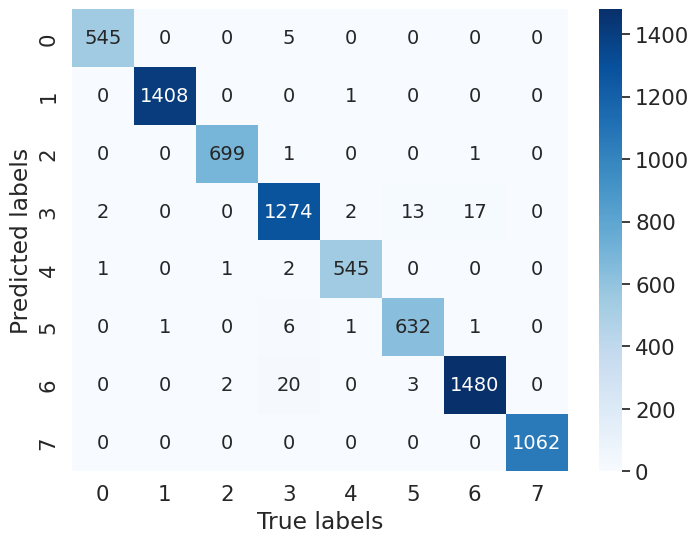

In [31]:
evaluations(model, ds=X_train, y_ds=y_train, labels=LABELS,name='training')

I0000 00:00:1731187717.714016     749 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(bdb4c5b647f4f05e:0:0), session_name()
I0000 00:00:1731187721.582594     749 tpu_compile_op_common.cc:245] Compilation of bdb4c5b647f4f05e:0:0 with session name  took 3.86853139s and succeeded
I0000 00:00:1731187721.604540     749 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(bdb4c5b647f4f05e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_17718952765016957596", property.function_library_fingerprint = 6533717834765745574, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partit

Accuracy score over the validation set: 0.9672
Precision score over the validation set: 0.9673
Recall score over the validation set: 0.9672
F1 score over the validation set: 0.9672


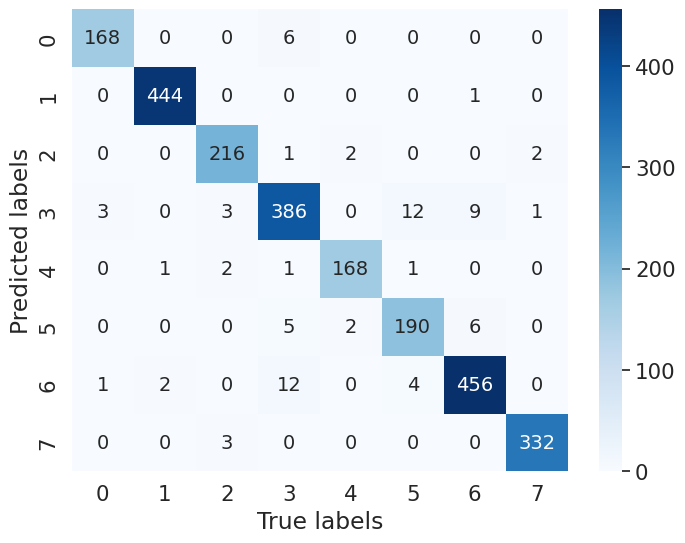

In [30]:
evaluations(model, ds=X_val, y_ds=y_val, labels=LABELS, name='validation')

Accuracy score over the test set: 0.9677
Precision score over the test set: 0.9677
Recall score over the test set: 0.9677
F1 score over the test set: 0.9676


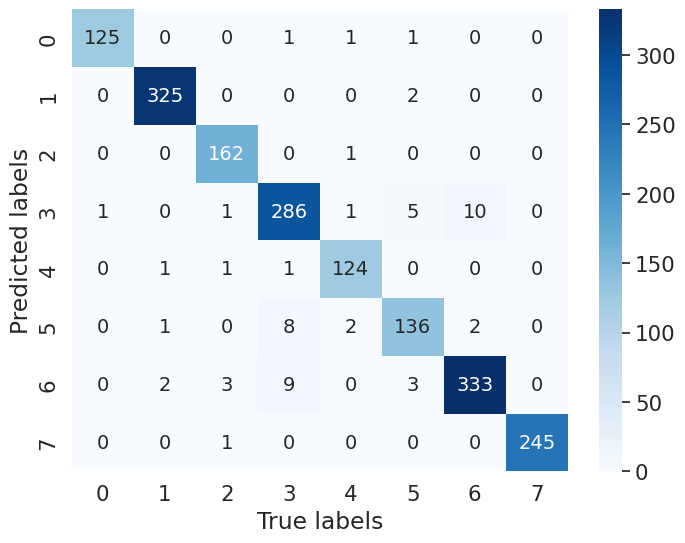

In [32]:
evaluations(model, ds=X_test, y_ds=y_test, labels=LABELS, name='test')

In [33]:
del model

## **FINE TUNING**

In [73]:
# Best values found so far
n_dense_layers = 3
dropout_rate = 0.35
include_dropout = True
l2_lambda = 2e-2

epochs = 100

In [74]:
# Build the model with specified input and output shapes
with strategy.scope():
    model = create_model(n_dense_layers=n_dense_layers, include_dropout=True, dropout_rate=dropout_rate, l2_lambda=l2_lambda, convnext_trainable=True)

model.trainable = True
for layer in model.get_layer('convnext_base').layers:
    layer.trainable = False
    


In [65]:
model.summary(show_trainable = True, expand_nested=True)

Model: "TF-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ custom_cast_layer_3         │ (None, 96, 96, 3)     │          0 │   -   │
│ (CustomCastLayer)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ custom_augment_layer_3      │ (None, 96, 96, 3)     │          0 │   -   │
│ (CustomAugmentLayer)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ convnext_base (Functional)  │ (None, 3, 3, 1024)    │ 87,566,464 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer_15         │ (None, 96, 96, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 96, 96, 3)     │          0 │   -   │
│ convnext_base_prestem_norm… │                       │            │       │
│ (Normalization)             │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ convnext_base_stem     │ (None, 24, 24, 128)   │      6,528 │   N   │
│ (Sequential)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └                     │ (None, 24, 24, 128)   │      6,272 │   N   │
│ convnext_base_stem_conv     │                       │            │       │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └                     │ (None, 24, 24, 128)   │        256 │   N   │
│ convnext_base_stem_layerno… │                       │            │       │
│ (LayerNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │      6,400 │   N   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │        256 │   N   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (LayerNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 512)   │     66,048 │   N   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (Dense)                     │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 512)   │          0 │   -   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │     65,664 │   N   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (Dense)                     │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │        128 │   N 

 Total params: 89,274,248 (340.55 MB)

 Trainable params: 1,707,784 (6.51 MB)

 Non-trainable params: 87,566,464 (334.04 MB)

In [75]:
# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(model.get_layer('convnext_base').layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

3 convnext_base_stage_0_block_0_depthwise_conv Conv2D True
10 convnext_base_stage_0_block_1_depthwise_conv Conv2D True
17 convnext_base_stage_0_block_2_depthwise_conv Conv2D True
25 convnext_base_stage_1_block_0_depthwise_conv Conv2D True
32 convnext_base_stage_1_block_1_depthwise_conv Conv2D True
39 convnext_base_stage_1_block_2_depthwise_conv Conv2D True
47 convnext_base_stage_2_block_0_depthwise_conv Conv2D True
54 convnext_base_stage_2_block_1_depthwise_conv Conv2D True
61 convnext_base_stage_2_block_2_depthwise_conv Conv2D True
68 convnext_base_stage_2_block_3_depthwise_conv Conv2D True
75 convnext_base_stage_2_block_4_depthwise_conv Conv2D True
82 convnext_base_stage_2_block_5_depthwise_conv Conv2D True
89 convnext_base_stage_2_block_6_depthwise_conv Conv2D True
96 convnext_base_stage_2_block_7_depthwise_conv Conv2D True
103 convnext_base_stage_2_block_8_depthwise_conv Conv2D True
110 convnext_base_stage_2_block_9_depthwise_conv Conv2D True
117 convnext_base_stage_2_block_10_dept

In [76]:
# Set the number of layers to freeze
N = 129

# Set the first N layers as non-trainable
for i, layer in enumerate(model.get_layer('convnext_base').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(model.get_layer('convnext_base').layers):
    print(i, layer.name, layer.trainable)

0 input_layer_20 False
1 convnext_base_prestem_normalization False
2 convnext_base_stem False
3 convnext_base_stage_0_block_0_depthwise_conv False
4 convnext_base_stage_0_block_0_layernorm False
5 convnext_base_stage_0_block_0_pointwise_conv_1 False
6 convnext_base_stage_0_block_0_gelu False
7 convnext_base_stage_0_block_0_pointwise_conv_2 False
8 convnext_base_stage_0_block_0_layer_scale False
9 convnext_base_stage_0_block_0_identity False
10 convnext_base_stage_0_block_1_depthwise_conv False
11 convnext_base_stage_0_block_1_layernorm False
12 convnext_base_stage_0_block_1_pointwise_conv_1 False
13 convnext_base_stage_0_block_1_gelu False
14 convnext_base_stage_0_block_1_pointwise_conv_2 False
15 convnext_base_stage_0_block_1_layer_scale False
16 convnext_base_stage_0_block_1_identity False
17 convnext_base_stage_0_block_2_depthwise_conv False
18 convnext_base_stage_0_block_2_layernorm False
19 convnext_base_stage_0_block_2_pointwise_conv_1 False
20 convnext_base_stage_0_block_2_gelu 

In [77]:
model.load_weights("MODEL.weights.h5")

In [78]:
# Define the patience value for early stopping
patience = 12

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

lr_reducer = CustomReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.5, patience=5, min_lr=1e-8)
plot_callback = RealTimePlot()

# Store the callback in a list
callbacks = [early_stopping, lr_reducer, plot_callback]

In [79]:
ds = train_dataset.concatenate(val_dataset)
ds = ds.shuffle(10240)

In [80]:
steps_per_epoch = (X_train.shape[0] + X_val.shape[0]) // batch_size
print(steps_per_epoch)

158


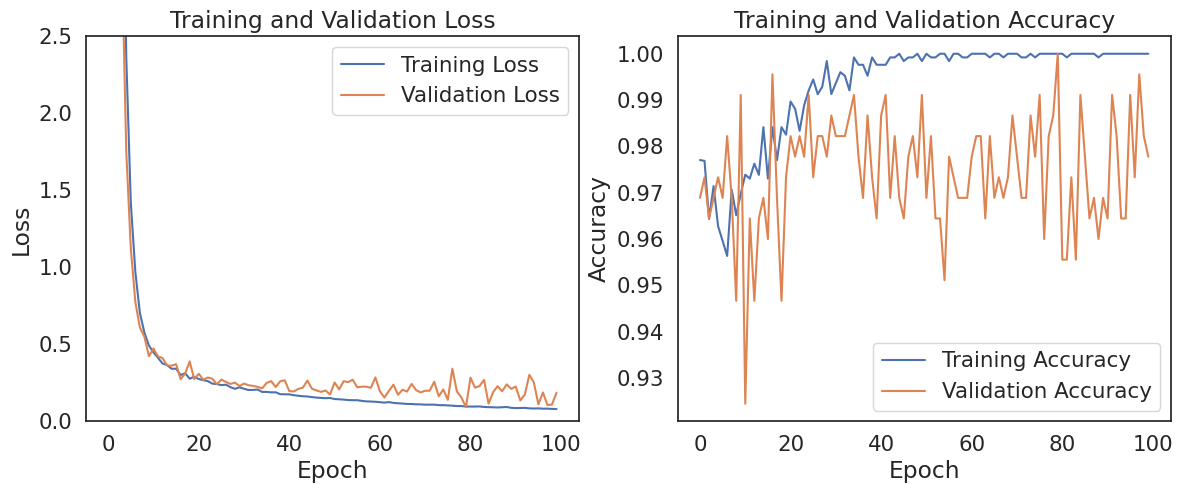

158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - categorical_accuracy: 1.0000 - loss: 0.0795 - val_categorical_accuracy: 0.9778 - val_loss: 0.1852


In [81]:
# Train the model with early stopping callback
history = model.fit(
    ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    callbacks=callbacks
).history

## **FINE TUNING EVALUATIONS**

In [82]:
X = np.concatenate([X_train, X_val], axis=0)
y = np.concatenate([y_train, y_val], axis=0)

I0000 00:00:1731190024.119579     764 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(7d0c919d842045e2:0:0), session_name()
I0000 00:00:1731190028.166948     764 tpu_compile_op_common.cc:245] Compilation of 7d0c919d842045e2:0:0 with session name  took 4.047326043s and succeeded
I0000 00:00:1731190028.187455     764 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(7d0c919d842045e2:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_3024733482901830956", property.function_library_fingerprint = 6516094257041677355, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,96,96,3,;", property.guaranteed_constants_size = 0, embed

Accuracy score over the training set: 0.9951
Precision score over the training set: 0.9951
Recall score over the training set: 0.9951
F1 score over the training set: 0.9951


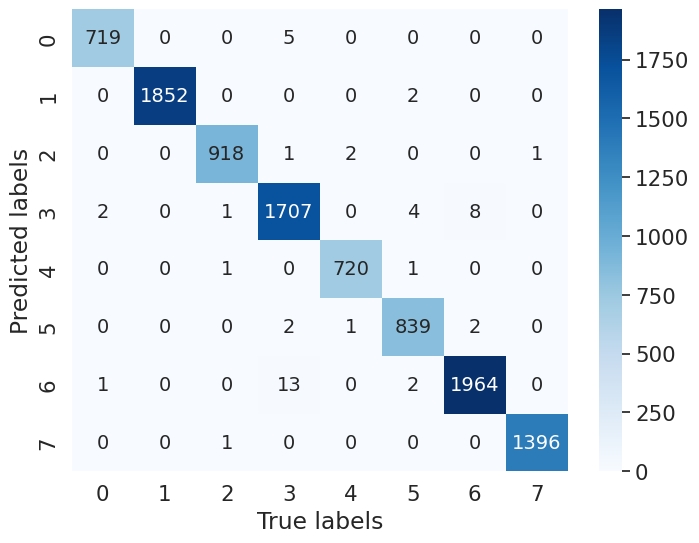

In [85]:
evaluations(model, ds=X, y_ds=y, labels=LABELS, name='training')

I0000 00:00:1731189983.761318     812 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ca2c647ab130c6d0:0:0), session_name()
I0000 00:00:1731189987.915276     812 tpu_compile_op_common.cc:245] Compilation of ca2c647ab130c6d0:0:0 with session name  took 4.153903518s and succeeded
I0000 00:00:1731189987.939222     812 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ca2c647ab130c6d0:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14590150179415707861", property.function_library_fingerprint = 4612672497666696165, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_parti

Accuracy score over the test/validation set: 0.9783
Precision score over the test/validation set: 0.9783
Recall score over the test/validation set: 0.9783
F1 score over the test/validation set: 0.9783


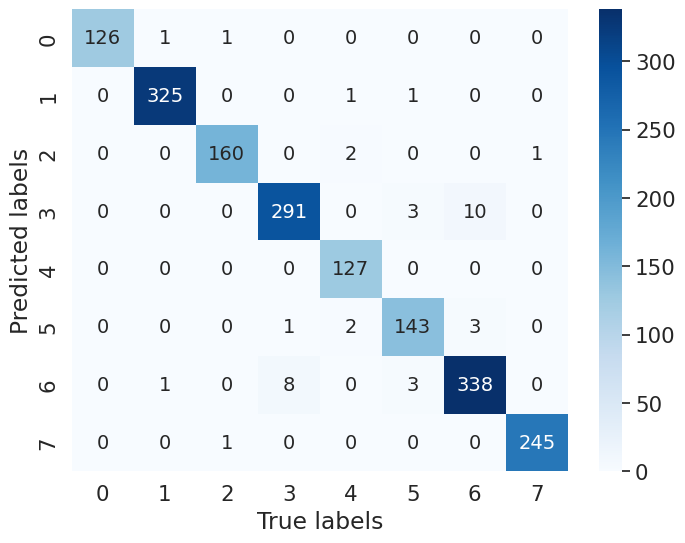

In [84]:
evaluations(model, ds=X_test, y_ds=y_test, labels=LABELS,name='test/validation')

In [86]:
# Save the trained model to a file with the accuracy included in the filename
with strategy.scope():
    model_weights_filename = 'FINAl_MODEL.weights.h5'
    model.save_weights(model_weights_filename)